In [1]:
from fetch_data import fetch_events, clear_events, load_csv_and_create_dataframe, load_credentials
import numpy as np
import json
import pandas as pd
from matplotlib import pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D, Flatten, Activation
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import mean_squared_error
plt.style.use('dark_background')
from sklearn.metrics import classification_report, confusion_matrix
import random
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.
/home/iago/jupyter-cuda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/iago/jupyter-cuda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/iago/jupyter-cuda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/iago/jupyter-cuda/lib/python3.6/site-packages/t

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2374177310200381828
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15531227068326434648
physical_device_desc: "device: XLA_CPU device"
]


In [2]:
def fetch_multiple_days (credentials, *days, equalize=False):
    
    purchases, regular_events = clear_events(fetch_events(credentials['user'], credentials['pwd'], days[0]).json()[0])
    
    data = load_csv_and_create_dataframe(purchases, 1)
    if equalize:
        data = load_csv_and_create_dataframe(sorted(regular_events, key=lambda x:random.random())[:len(purchases)], 0, data)
    else:
        data = load_csv_and_create_dataframe(regular_events, 0, data)
        
    for day in days[1:]:
        purchases, regular_events = clear_events(fetch_events(credentials['user'], credentials['pwd'], day).json()[0])
        data = load_csv_and_create_dataframe(purchases, 1, data)
        if equalize:
            data = load_csv_and_create_dataframe(sorted(regular_events, key=lambda x:random.random())[:len(purchases)], 0, data)
        else:
            data = load_csv_and_create_dataframe(regular_events, 0, data)
    return data

## Fetching train and test data

In [3]:
load_credentials()
credentials = {}
with open('credentials_visio.json') as creds:
    credentials = json.load(creds)
train_data = fetch_multiple_days(credentials, '2020-01-30', '2020-01-28', '2020-01-27', '2020-01-25', '2020-01-24', '2020-01-13', '2020-01-20')
test_data = fetch_multiple_days(credentials, '2020-01-30', equalize=False)

Login succed
Login succed
Login succed
Login succed
Login succed
Login succed
Login succed
Login succed


In [4]:
def generate_x_data(data): 
    data['pos'] = data['pos'].apply(lambda x: np.array([list(map(float, value.replace('(','[').replace(')',']').replace('[','').replace(']','').split(', '))) for value in x]))
    data['len'] = data['pos'].apply(len)
    data['x'] = data['pos'].apply(lambda x: [data[0] for data in x])
    data['y'] = data['pos'].apply(lambda x: [data[1] for data in x])
    data['sizex'] = data['pos'].apply(lambda x: [data[2] for data in x])
    data['sizey'] = data['pos'].apply(lambda x: [data[3] for data in x])
    
    return data

In [5]:
train_Data = train_data.copy()
train_Data = generate_x_data(train_Data)
feature_dimention = 4

test_Data = test_data.copy()
test_Data = generate_x_data(test_Data)

max_phrase_len = min(test_Data['len'].max() if test_Data['len'].max() > test_Data['len'].max() else test_Data['len'].max(), 3000)
feature_dimention = 4

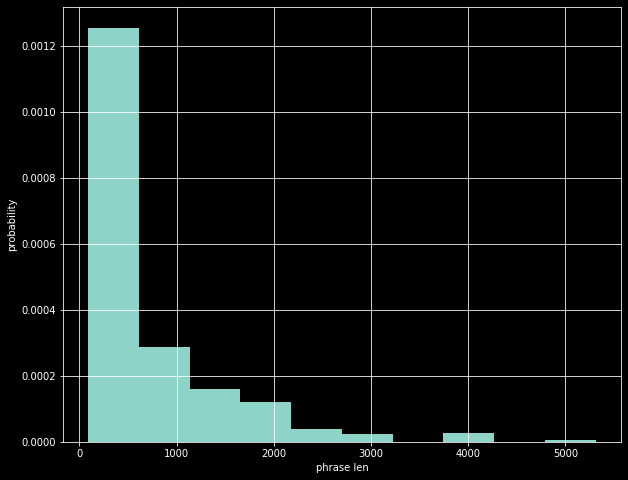

In [6]:
plt.figure(figsize = (10, 8))
plt.hist(test_Data['len'], density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid()

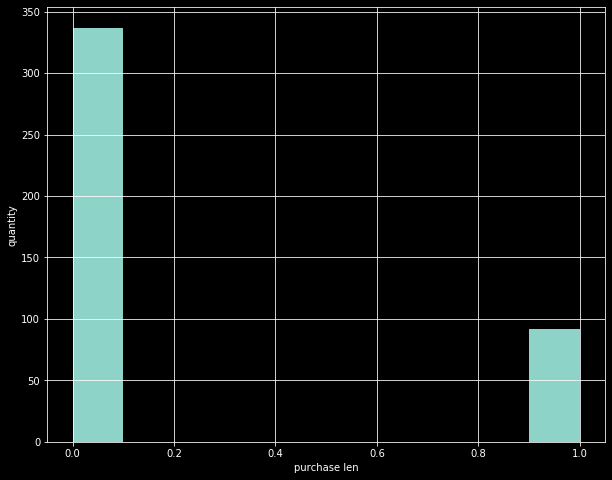

In [7]:
plt.figure(figsize = (10, 8))
plt.hist(test_Data['purchase'])
plt.xlabel('purchase len')
plt.ylabel('quantity')
plt.grid()

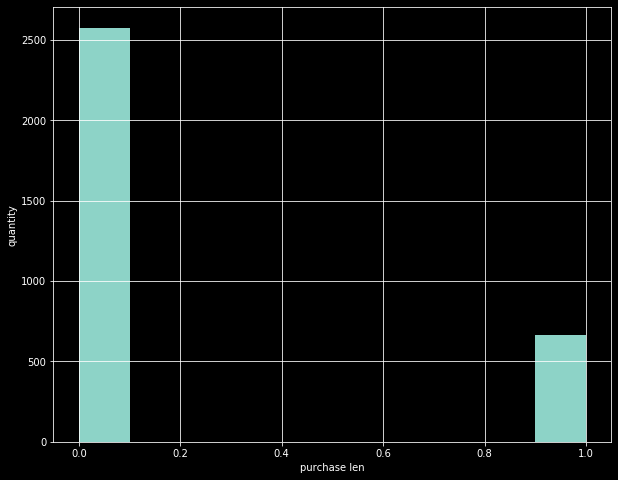

In [8]:
plt.figure(figsize = (10, 8))
plt.hist(train_Data['purchase'])
plt.xlabel('purchase len')
plt.ylabel('quantity')
plt.grid()

In [9]:
test_Data.describe()

,len
count,429.000000
mean,649.121212
std,796.967465
min,92.000000
25%,127.000000
50%,294.000000
75%,904.000000
max,5312.000000


In [10]:
def normalize(arr):
    norm = arr - arr.min()
    norm = norm / np.abs(norm).max()
    
    return norm

In [22]:
batch_size = 50
epochs = 1000

In [23]:
Y_train = train_Data['purchase']

X_x_train = pad_sequences(train_Data['x'], maxlen = max_phrase_len) 
X_y_train = pad_sequences(train_Data['y'], maxlen = max_phrase_len)
X_szx_train = pad_sequences(train_Data['sizex'], maxlen = max_phrase_len)
X_szy_train = pad_sequences(train_Data['sizey'], maxlen = max_phrase_len)

y_train = to_categorical(Y_train)
x_train = np.array(list(zip(X_x_train, X_y_train, X_szx_train, X_szy_train)))

In [24]:
Y_test = test_Data['purchase']

X_x_test = pad_sequences(test_Data['x'], maxlen = max_phrase_len) 
X_y_test = pad_sequences(test_Data['y'], maxlen = max_phrase_len)
X_szx_test = pad_sequences(test_Data['sizex'], maxlen = max_phrase_len)
X_szy_test = pad_sequences(test_Data['sizey'], maxlen = max_phrase_len)

y_test = to_categorical(Y_test)
x_test = np.array(list(zip(X_x_test, X_y_test, X_szx_test, X_szy_test)))

In [25]:
model_lstm = Sequential()
# model_lstm.add(Embedding(input_dim = 4, output_dim = 256, input_length = max_phrase_len))
# model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(64, input_shape=(4, max_phrase_len), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(64, input_shape=(4, max_phrase_len), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(64, input_shape=(4, max_phrase_len)))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(2, activation='softmax'))
#model_lstm.add(Flatten())
model_lstm.summary()

model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['acc']
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 4, 64)             784640    
_________________________________________________________________
dropout_10 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 4, 64)             33024     
_________________________________________________________________
dropout_11 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

In [26]:
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split = 0.1,
    epochs = epochs,
    batch_size = batch_size,
    verbose=1
)

Train on 2916 samples, validate on 324 samples
Epoch 1/1000
2916/2916 [==============================] - 2s 732us/step - loss: 0.3382 - acc: 0.8447 - val_loss: 0.2963 - val_acc: 0.7654
Epoch 2/1000
2916/2916 [==============================] - 1s 268us/step - loss: 0.3011 - acc: 0.8553 - val_loss: 0.2835 - val_acc: 0.7870
Epoch 3/1000
2916/2916 [==============================] - 1s 260us/step - loss: 0.3007 - acc: 0.8495 - val_loss: 0.2904 - val_acc: 0.7963
Epoch 4/1000
2916/2916 [==============================] - 1s 263us/step - loss: 0.3016 - acc: 0.8491 - val_loss: 0.2903 - val_acc: 0.7716
Epoch 5/1000
2916/2916 [==============================] - 1s 265us/step - loss: 0.3082 - acc: 0.8471 - val_loss: 0.2473 - val_acc: 0.8488
Epoch 6/1000
2916/2916 [==============================] - 1s 268us/step - loss: 0.3033 - acc: 0.8505 - val_loss: 0.2621 - val_acc: 0.8086
Epoch 7/1000
2916/2916 [==============================] - 1s 271us/step - loss: 0.3002 - acc: 0.8505 - val_loss: 0.2718 - val

2916/2916 [==============================] - 1s 275us/step - loss: 0.2889 - acc: 0.8608 - val_loss: 0.3274 - val_acc: 0.7809
Epoch 60/1000
2916/2916 [==============================] - 1s 275us/step - loss: 0.2878 - acc: 0.8656 - val_loss: 0.2958 - val_acc: 0.7901
Epoch 61/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.3025 - acc: 0.8584 - val_loss: 0.2124 - val_acc: 0.9012
Epoch 62/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.3009 - acc: 0.8611 - val_loss: 0.3068 - val_acc: 0.7901
Epoch 63/1000
2916/2916 [==============================] - 1s 273us/step - loss: 0.2904 - acc: 0.8639 - val_loss: 0.2874 - val_acc: 0.8148
Epoch 64/1000
2916/2916 [==============================] - 1s 273us/step - loss: 0.2879 - acc: 0.8632 - val_loss: 0.2831 - val_acc: 0.7963
Epoch 65/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2872 - acc: 0.8652 - val_loss: 0.2856 - val_acc: 0.7932
Epoch 66/1000
2916/2916 [================

Epoch 118/1000
2916/2916 [==============================] - 1s 268us/step - loss: 0.2800 - acc: 0.8639 - val_loss: 0.2941 - val_acc: 0.7963
Epoch 119/1000
2916/2916 [==============================] - 1s 266us/step - loss: 0.2773 - acc: 0.8676 - val_loss: 0.3034 - val_acc: 0.7994
Epoch 120/1000
2916/2916 [==============================] - 1s 262us/step - loss: 0.2807 - acc: 0.8639 - val_loss: 0.2943 - val_acc: 0.7932
Epoch 121/1000
2916/2916 [==============================] - 1s 261us/step - loss: 0.2827 - acc: 0.8587 - val_loss: 0.3003 - val_acc: 0.7963
Epoch 122/1000
2916/2916 [==============================] - 1s 260us/step - loss: 0.2782 - acc: 0.8680 - val_loss: 0.3050 - val_acc: 0.7994
Epoch 123/1000
2916/2916 [==============================] - 1s 261us/step - loss: 0.2752 - acc: 0.8683 - val_loss: 0.2705 - val_acc: 0.8148
Epoch 124/1000
2916/2916 [==============================] - 1s 262us/step - loss: 0.2758 - acc: 0.8676 - val_loss: 0.3183 - val_acc: 0.8148
Epoch 125/1000
2916/

2916/2916 [==============================] - 1s 269us/step - loss: 0.2741 - acc: 0.8765 - val_loss: 0.3073 - val_acc: 0.8025
Epoch 177/1000
2916/2916 [==============================] - 1s 269us/step - loss: 0.2667 - acc: 0.8776 - val_loss: 0.2952 - val_acc: 0.8210
Epoch 178/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2687 - acc: 0.8731 - val_loss: 0.3088 - val_acc: 0.7994
Epoch 179/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2663 - acc: 0.8717 - val_loss: 0.3269 - val_acc: 0.8056
Epoch 180/1000
2916/2916 [==============================] - 1s 275us/step - loss: 0.2635 - acc: 0.8735 - val_loss: 0.3027 - val_acc: 0.8210
Epoch 181/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2598 - acc: 0.8796 - val_loss: 0.2777 - val_acc: 0.8302
Epoch 182/1000
2916/2916 [==============================] - 1s 272us/step - loss: 0.2625 - acc: 0.8759 - val_loss: 0.2569 - val_acc: 0.8272
Epoch 183/1000
2916/2916 [=========

2916/2916 [==============================] - 1s 261us/step - loss: 0.2689 - acc: 0.8724 - val_loss: 0.2764 - val_acc: 0.8117
Epoch 235/1000
2916/2916 [==============================] - 1s 261us/step - loss: 0.2633 - acc: 0.8776 - val_loss: 0.3334 - val_acc: 0.7716
Epoch 236/1000
2916/2916 [==============================] - 1s 262us/step - loss: 0.2631 - acc: 0.8735 - val_loss: 0.3139 - val_acc: 0.8025
Epoch 237/1000
2916/2916 [==============================] - 1s 268us/step - loss: 0.2636 - acc: 0.8724 - val_loss: 0.3427 - val_acc: 0.7809
Epoch 238/1000
2916/2916 [==============================] - 1s 273us/step - loss: 0.2628 - acc: 0.8741 - val_loss: 0.2920 - val_acc: 0.8179
Epoch 239/1000
2916/2916 [==============================] - 1s 273us/step - loss: 0.2717 - acc: 0.8642 - val_loss: 0.3111 - val_acc: 0.8148
Epoch 240/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2679 - acc: 0.8697 - val_loss: 0.3328 - val_acc: 0.7963
Epoch 241/1000
2916/2916 [=========

2916/2916 [==============================] - 1s 274us/step - loss: 0.2610 - acc: 0.8683 - val_loss: 0.3577 - val_acc: 0.7377
Epoch 293/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2640 - acc: 0.8786 - val_loss: 0.2902 - val_acc: 0.8210
Epoch 294/1000
2916/2916 [==============================] - 1s 273us/step - loss: 0.2623 - acc: 0.8680 - val_loss: 0.2997 - val_acc: 0.7809
Epoch 295/1000
2916/2916 [==============================] - 1s 275us/step - loss: 0.2637 - acc: 0.8714 - val_loss: 0.3126 - val_acc: 0.7901
Epoch 296/1000
2916/2916 [==============================] - 1s 275us/step - loss: 0.2682 - acc: 0.8711 - val_loss: 0.3254 - val_acc: 0.7840
Epoch 297/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2647 - acc: 0.8693 - val_loss: 0.3309 - val_acc: 0.7840
Epoch 298/1000
2916/2916 [==============================] - 1s 275us/step - loss: 0.2686 - acc: 0.8673 - val_loss: 0.3010 - val_acc: 0.7716
Epoch 299/1000
2916/2916 [=========

2916/2916 [==============================] - 1s 273us/step - loss: 0.2631 - acc: 0.8728 - val_loss: 0.3272 - val_acc: 0.7747
Epoch 351/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2655 - acc: 0.8707 - val_loss: 0.3347 - val_acc: 0.7870
Epoch 352/1000
2916/2916 [==============================] - 1s 275us/step - loss: 0.2636 - acc: 0.8738 - val_loss: 0.3168 - val_acc: 0.7901
Epoch 353/1000
2916/2916 [==============================] - 1s 273us/step - loss: 0.2641 - acc: 0.8731 - val_loss: 0.2778 - val_acc: 0.8364
Epoch 354/1000
2916/2916 [==============================] - 1s 276us/step - loss: 0.2626 - acc: 0.8666 - val_loss: 0.3125 - val_acc: 0.8025
Epoch 355/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2635 - acc: 0.8707 - val_loss: 0.3051 - val_acc: 0.7901
Epoch 356/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2654 - acc: 0.8690 - val_loss: 0.3046 - val_acc: 0.7932
Epoch 357/1000
2916/2916 [=========

2916/2916 [==============================] - 1s 273us/step - loss: 0.2575 - acc: 0.8783 - val_loss: 0.3273 - val_acc: 0.7840
Epoch 409/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2509 - acc: 0.8786 - val_loss: 0.3151 - val_acc: 0.7809
Epoch 410/1000
2916/2916 [==============================] - 1s 275us/step - loss: 0.2562 - acc: 0.8772 - val_loss: 0.3180 - val_acc: 0.7685
Epoch 411/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2563 - acc: 0.8738 - val_loss: 0.3318 - val_acc: 0.7685
Epoch 412/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2522 - acc: 0.8810 - val_loss: 0.3267 - val_acc: 0.7809
Epoch 413/1000
2916/2916 [==============================] - 1s 273us/step - loss: 0.2525 - acc: 0.8789 - val_loss: 0.3164 - val_acc: 0.7809
Epoch 414/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2532 - acc: 0.8769 - val_loss: 0.3079 - val_acc: 0.7932
Epoch 415/1000
2916/2916 [=========

2916/2916 [==============================] - 1s 266us/step - loss: 0.2678 - acc: 0.8687 - val_loss: 0.3424 - val_acc: 0.7809
Epoch 467/1000
2916/2916 [==============================] - 1s 265us/step - loss: 0.2703 - acc: 0.8642 - val_loss: 0.3314 - val_acc: 0.7778
Epoch 468/1000
2916/2916 [==============================] - 1s 266us/step - loss: 0.2657 - acc: 0.8731 - val_loss: 0.3363 - val_acc: 0.7778
Epoch 469/1000
2916/2916 [==============================] - 1s 269us/step - loss: 0.2654 - acc: 0.8652 - val_loss: 0.3269 - val_acc: 0.7870
Epoch 470/1000
2916/2916 [==============================] - 1s 270us/step - loss: 0.2656 - acc: 0.8731 - val_loss: 0.3474 - val_acc: 0.7932
Epoch 471/1000
2916/2916 [==============================] - 1s 269us/step - loss: 0.2667 - acc: 0.8711 - val_loss: 0.3102 - val_acc: 0.7901
Epoch 472/1000
2916/2916 [==============================] - 1s 268us/step - loss: 0.2656 - acc: 0.8714 - val_loss: 0.2606 - val_acc: 0.8364
Epoch 473/1000
2916/2916 [=========

2916/2916 [==============================] - 1s 273us/step - loss: 0.2542 - acc: 0.8813 - val_loss: 0.3036 - val_acc: 0.7870
Epoch 525/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2585 - acc: 0.8738 - val_loss: 0.2867 - val_acc: 0.7932
Epoch 526/1000
2916/2916 [==============================] - 1s 264us/step - loss: 0.2492 - acc: 0.8855 - val_loss: 0.3495 - val_acc: 0.7778
Epoch 527/1000
2916/2916 [==============================] - 1s 269us/step - loss: 0.2506 - acc: 0.8755 - val_loss: 0.3001 - val_acc: 0.8056
Epoch 528/1000
2916/2916 [==============================] - 1s 270us/step - loss: 0.2466 - acc: 0.8879 - val_loss: 0.3209 - val_acc: 0.8117
Epoch 529/1000
2916/2916 [==============================] - 1s 269us/step - loss: 0.2561 - acc: 0.8772 - val_loss: 0.3227 - val_acc: 0.7901
Epoch 530/1000
2916/2916 [==============================] - 1s 273us/step - loss: 0.2427 - acc: 0.8783 - val_loss: 0.3191 - val_acc: 0.8056
Epoch 531/1000
2916/2916 [=========

2916/2916 [==============================] - 1s 264us/step - loss: 0.2556 - acc: 0.8807 - val_loss: 0.2905 - val_acc: 0.8272
Epoch 583/1000
2916/2916 [==============================] - 1s 265us/step - loss: 0.2432 - acc: 0.8875 - val_loss: 0.3056 - val_acc: 0.7994
Epoch 584/1000
2916/2916 [==============================] - 1s 273us/step - loss: 0.2452 - acc: 0.8872 - val_loss: 0.2888 - val_acc: 0.8148
Epoch 585/1000
2916/2916 [==============================] - 1s 275us/step - loss: 0.2460 - acc: 0.8844 - val_loss: 0.3068 - val_acc: 0.8056
Epoch 586/1000
2916/2916 [==============================] - 1s 275us/step - loss: 0.2443 - acc: 0.8858 - val_loss: 0.3037 - val_acc: 0.8148
Epoch 587/1000
2916/2916 [==============================] - 1s 275us/step - loss: 0.2448 - acc: 0.8851 - val_loss: 0.2838 - val_acc: 0.8148
Epoch 588/1000
2916/2916 [==============================] - 1s 273us/step - loss: 0.2499 - acc: 0.8944 - val_loss: 0.3056 - val_acc: 0.8117
Epoch 589/1000
2916/2916 [=========

2916/2916 [==============================] - 1s 268us/step - loss: 0.2497 - acc: 0.8827 - val_loss: 0.3266 - val_acc: 0.7994
Epoch 641/1000
2916/2916 [==============================] - 1s 270us/step - loss: 0.2451 - acc: 0.8837 - val_loss: 0.3317 - val_acc: 0.7901
Epoch 642/1000
2916/2916 [==============================] - 1s 269us/step - loss: 0.2505 - acc: 0.8796 - val_loss: 0.3365 - val_acc: 0.7840
Epoch 643/1000
2916/2916 [==============================] - 1s 269us/step - loss: 0.2460 - acc: 0.8837 - val_loss: 0.3414 - val_acc: 0.7840
Epoch 644/1000
2916/2916 [==============================] - 1s 269us/step - loss: 0.2402 - acc: 0.8906 - val_loss: 0.3435 - val_acc: 0.7932
Epoch 645/1000
2916/2916 [==============================] - 1s 270us/step - loss: 0.2504 - acc: 0.8779 - val_loss: 0.3358 - val_acc: 0.7932
Epoch 646/1000
2916/2916 [==============================] - 1s 273us/step - loss: 0.2505 - acc: 0.8783 - val_loss: 0.3148 - val_acc: 0.7901
Epoch 647/1000
2916/2916 [=========

2916/2916 [==============================] - 1s 265us/step - loss: 0.2482 - acc: 0.8820 - val_loss: 0.3483 - val_acc: 0.7840
Epoch 699/1000
2916/2916 [==============================] - 1s 267us/step - loss: 0.2499 - acc: 0.8769 - val_loss: 0.3193 - val_acc: 0.8056
Epoch 700/1000
2916/2916 [==============================] - 1s 265us/step - loss: 0.2439 - acc: 0.8855 - val_loss: 0.3751 - val_acc: 0.7840
Epoch 701/1000
2916/2916 [==============================] - 1s 266us/step - loss: 0.2517 - acc: 0.8755 - val_loss: 0.3041 - val_acc: 0.8056
Epoch 702/1000
2916/2916 [==============================] - 1s 265us/step - loss: 0.2522 - acc: 0.8810 - val_loss: 0.3036 - val_acc: 0.8056
Epoch 703/1000
2916/2916 [==============================] - 1s 265us/step - loss: 0.2472 - acc: 0.8759 - val_loss: 0.3076 - val_acc: 0.8056
Epoch 704/1000
2916/2916 [==============================] - 1s 266us/step - loss: 0.2494 - acc: 0.8800 - val_loss: 0.3209 - val_acc: 0.8210
Epoch 705/1000
2916/2916 [=========

2916/2916 [==============================] - 1s 273us/step - loss: 0.2519 - acc: 0.8714 - val_loss: 0.3189 - val_acc: 0.7932
Epoch 757/1000
2916/2916 [==============================] - 1s 261us/step - loss: 0.2468 - acc: 0.8834 - val_loss: 0.3376 - val_acc: 0.7963
Epoch 758/1000
2916/2916 [==============================] - 1s 263us/step - loss: 0.2422 - acc: 0.8779 - val_loss: 0.3345 - val_acc: 0.8025
Epoch 759/1000
2916/2916 [==============================] - 1s 261us/step - loss: 0.2450 - acc: 0.8803 - val_loss: 0.3683 - val_acc: 0.8086
Epoch 760/1000
2916/2916 [==============================] - 1s 260us/step - loss: 0.2491 - acc: 0.8827 - val_loss: 0.3392 - val_acc: 0.8148
Epoch 761/1000
2916/2916 [==============================] - 1s 262us/step - loss: 0.2428 - acc: 0.8844 - val_loss: 0.3582 - val_acc: 0.7994
Epoch 762/1000
2916/2916 [==============================] - 1s 262us/step - loss: 0.2388 - acc: 0.8848 - val_loss: 0.3062 - val_acc: 0.7963
Epoch 763/1000
2916/2916 [=========

2916/2916 [==============================] - 1s 267us/step - loss: 0.2477 - acc: 0.8728 - val_loss: 0.3446 - val_acc: 0.7994
Epoch 815/1000
2916/2916 [==============================] - 1s 262us/step - loss: 0.2468 - acc: 0.8783 - val_loss: 0.3273 - val_acc: 0.8395
Epoch 816/1000
2916/2916 [==============================] - 1s 262us/step - loss: 0.2515 - acc: 0.8676 - val_loss: 0.3342 - val_acc: 0.8457
Epoch 817/1000
2916/2916 [==============================] - 1s 262us/step - loss: 0.2495 - acc: 0.8786 - val_loss: 0.3372 - val_acc: 0.8210
Epoch 818/1000
2916/2916 [==============================] - 1s 260us/step - loss: 0.2508 - acc: 0.8769 - val_loss: 0.3541 - val_acc: 0.8086
Epoch 819/1000
2916/2916 [==============================] - 1s 262us/step - loss: 0.2465 - acc: 0.8783 - val_loss: 0.3238 - val_acc: 0.8395
Epoch 820/1000
2916/2916 [==============================] - 1s 262us/step - loss: 0.2439 - acc: 0.8786 - val_loss: 0.3520 - val_acc: 0.8210
Epoch 821/1000
2916/2916 [=========

2916/2916 [==============================] - 1s 275us/step - loss: 0.2458 - acc: 0.8810 - val_loss: 0.3444 - val_acc: 0.7747
Epoch 873/1000
2916/2916 [==============================] - 1s 272us/step - loss: 0.2433 - acc: 0.8807 - val_loss: 0.2880 - val_acc: 0.8117
Epoch 874/1000
2916/2916 [==============================] - 1s 266us/step - loss: 0.2508 - acc: 0.8820 - val_loss: 0.3119 - val_acc: 0.7901
Epoch 875/1000
2916/2916 [==============================] - 1s 261us/step - loss: 0.2392 - acc: 0.8865 - val_loss: 0.3419 - val_acc: 0.7870
Epoch 876/1000
2916/2916 [==============================] - 1s 261us/step - loss: 0.2445 - acc: 0.8861 - val_loss: 0.2982 - val_acc: 0.8117
Epoch 877/1000
2916/2916 [==============================] - 1s 262us/step - loss: 0.2435 - acc: 0.8820 - val_loss: 0.3342 - val_acc: 0.7809
Epoch 878/1000
2916/2916 [==============================] - 1s 265us/step - loss: 0.2436 - acc: 0.8872 - val_loss: 0.3179 - val_acc: 0.7932
Epoch 879/1000
2916/2916 [=========

2916/2916 [==============================] - 1s 274us/step - loss: 0.2467 - acc: 0.8865 - val_loss: 0.3442 - val_acc: 0.7840
Epoch 931/1000
2916/2916 [==============================] - 1s 270us/step - loss: 0.2384 - acc: 0.8909 - val_loss: 0.3411 - val_acc: 0.7932
Epoch 932/1000
2916/2916 [==============================] - 1s 270us/step - loss: 0.2381 - acc: 0.8916 - val_loss: 0.3418 - val_acc: 0.8056
Epoch 933/1000
2916/2916 [==============================] - 1s 269us/step - loss: 0.2407 - acc: 0.8861 - val_loss: 0.3562 - val_acc: 0.7901
Epoch 934/1000
2916/2916 [==============================] - 1s 270us/step - loss: 0.2310 - acc: 0.8848 - val_loss: 0.3431 - val_acc: 0.8148
Epoch 935/1000
2916/2916 [==============================] - 1s 269us/step - loss: 0.2352 - acc: 0.8882 - val_loss: 0.3312 - val_acc: 0.8148
Epoch 936/1000
2916/2916 [==============================] - 1s 269us/step - loss: 0.2348 - acc: 0.8875 - val_loss: 0.3543 - val_acc: 0.7840
Epoch 937/1000
2916/2916 [=========

2916/2916 [==============================] - 1s 273us/step - loss: 0.2417 - acc: 0.8820 - val_loss: 0.3255 - val_acc: 0.8056
Epoch 989/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2355 - acc: 0.8927 - val_loss: 0.3120 - val_acc: 0.8025
Epoch 990/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2429 - acc: 0.8837 - val_loss: 0.3441 - val_acc: 0.7901
Epoch 991/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2437 - acc: 0.8820 - val_loss: 0.3406 - val_acc: 0.7870
Epoch 992/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2479 - acc: 0.8831 - val_loss: 0.3631 - val_acc: 0.7809
Epoch 993/1000
2916/2916 [==============================] - 1s 273us/step - loss: 0.2433 - acc: 0.8868 - val_loss: 0.3223 - val_acc: 0.7932
Epoch 994/1000
2916/2916 [==============================] - 1s 274us/step - loss: 0.2434 - acc: 0.8800 - val_loss: 0.3219 - val_acc: 0.8025
Epoch 995/1000
2916/2916 [=========

In [ ]:
score = model_lstm.evaluate(x_test, y_test, verbose=1)
print (score)

In [ ]:
y_pred = model_lstm.predict(x_test)

In [304]:
purchases = []
for result, classes, _id, compra in zip(testPredict, y_test, test_data['id'], test_data['purchase']):
    print (f"{_id} {'Nada' if result[0] > 0.95 else 'Compr' if result[1] > 0.8 else 'Sece'} {'Compr' if compra == 1 else 'Nada'} {result[1]}")

1580407200_022 Sece Compr 0.7355793118476868
1580407200_056 Sece Compr 0.548132598400116
1580392800_045 Sece Compr 0.6805794835090637
1580395200_029 Sece Compr 0.7046114206314087
1580395200_038 Sece Compr 0.548132598400116
1580395200_040 Nada Compr 0.014209856279194355
1580395200_074 Sece Compr 0.7046114206314087
1580403600_017 Sece Compr 0.42510196566581726
1580404800_000 Sece Compr 0.7454246282577515
1580404800_001 Sece Compr 0.7241016626358032
1580404800_073 Sece Compr 0.6805794835090637
1580406000_072 Sece Compr 0.7241016626358032
1580408400_030 Sece Compr 0.24812942743301392
1580408400_049 Sece Compr 0.24812942743301392
1580408400_053 Sece Compr 0.548132598400116
1580408400_061 Sece Compr 0.24931572377681732
1580408400_069 Sece Compr 0.7046114206314087
1580412000_104 Sece Compr 0.7178678512573242
1580413200_002 Sece Compr 0.3183594048023224
1580413200_046 Sece Compr 0.7241016626358032
1580413200_071 Sece Compr 0.548132598400116
1580414400_037 Nada Compr 0.0135585842654109
15804144

In [305]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [306]:
print(matrix)

[[208 129]
 [ 76  16]]


In [237]:
[['tp', 'fp'],['fn', 'tn']]

[['tp', 'fp'], ['fn', 'tn']]

In [121]:
model_lstm.save('purchase_classification_20200131.h5')